In [113]:
from __future__ import absolute_import, division, print_function, unicode_literals
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [114]:
dataset_filename_csv = "runes_dataset.csv"
df = pd.read_csv(dataset_filename_csv)
#df.set_index('timestamp')
df.head()

,timestamp,Fire_rune,Water_rune,Air_rune,Earth_rune,Mind_rune,Body_rune,Death_rune,Nature_rune,Chaos_rune,Law_rune,Cosmic_rune,Blood_rune,Soul_rune
0,1616025600000,5,4,4,4,3,5,203,191,46,144,159,390,143
1,1616112000000,4,4,4,4,3,5,202,187,47,144,154,389,143
2,1616198400000,5,5,5,4,3,5,201,188,47,144,153,390,143
3,1616284800000,5,5,5,4,3,5,198,185,47,141,148,387,140
4,1616371200000,5,5,5,5,3,5,197,186,47,134,140,384,134


In [115]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

In [116]:
TRAIN_SPLIT = 140

In [117]:
tf.random.set_seed(13)

In [118]:
uni_data = df['Chaos_rune']
uni_data.index = df['timestamp']
uni_data.head()

timestamp
1616025600000    46
1616112000000    47
1616198400000    47
1616284800000    47
1616371200000    47
Name: Chaos_rune, dtype: int64

array([<AxesSubplot:xlabel='timestamp'>], dtype=object)

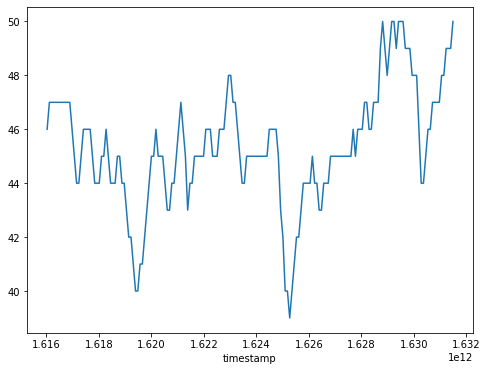

In [119]:
uni_data.plot(subplots=True)

In [120]:
uni_data = uni_data.values

In [121]:
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

In [122]:
uni_data = (uni_data-uni_train_mean)/uni_train_std

In [123]:
univariate_past_history = 10
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

In [124]:
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target price to predict')
print (y_train_uni[0])

Single window of past history
[[0.78540991]
 [1.36110304]
 [1.36110304]
 [1.36110304]
 [1.36110304]
 [1.36110304]
 [1.36110304]
 [1.36110304]
 [1.36110304]
 [1.36110304]]

 Target price to predict
1.3611030446536143


In [125]:
def create_time_steps(length):
  time_steps = []
  for i in range(-length, 0, 1):
    time_steps.append(i)
  return time_steps

In [126]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

<module 'matplotlib.pyplot' from 'c:\\users\\user\\appdata\\local\\programs\\python\\python37\\lib\\site-packages\\matplotlib\\pyplot.py'>

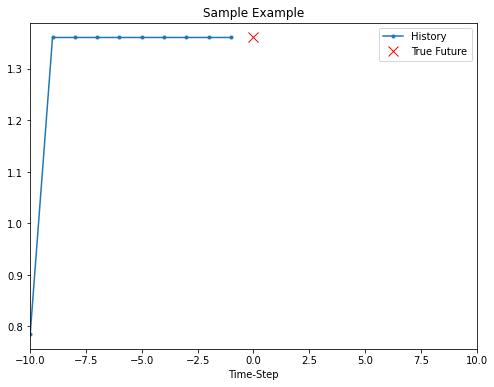

In [127]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

In [128]:
def baseline(history):
  return np.mean(history)

<module 'matplotlib.pyplot' from 'c:\\users\\user\\appdata\\local\\programs\\python\\python37\\lib\\site-packages\\matplotlib\\pyplot.py'>

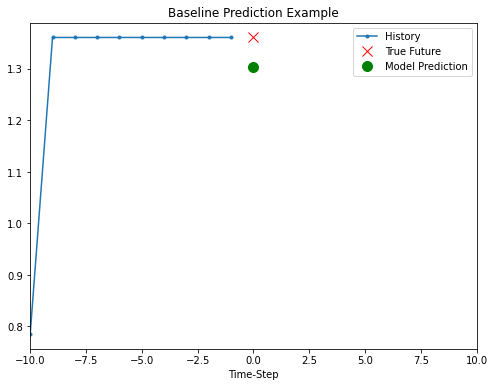

In [129]:
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,
           'Baseline Prediction Example')

In [130]:
BATCH_SIZE = 20
BUFFER_SIZE = 5

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [131]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

In [132]:
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

(20, 1)


In [133]:
EVALUATION_INTERVAL = 500
EPOCHS = 15

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

Epoch 1/15
500/500 [==============================] - 4s 5ms/step - loss: 0.5229 - val_loss: 1.2962
Epoch 2/15
500/500 [==============================] - 2s 4ms/step - loss: 0.3106 - val_loss: 1.2090
Epoch 3/15
500/500 [==============================] - 2s 4ms/step - loss: 0.2753 - val_loss: 1.2548
Epoch 4/15
500/500 [==============================] - 2s 4ms/step - loss: 0.2659 - val_loss: 1.2410
Epoch 5/15
500/500 [==============================] - 2s 4ms/step - loss: 0.2560 - val_loss: 1.2029
Epoch 6/15
500/500 [==============================] - 2s 4ms/step - loss: 0.2483 - val_loss: 1.1362
Epoch 7/15
500/500 [==============================] - 2s 4ms/step - loss: 0.2403 - val_loss: 1.0796
Epoch 8/15
500/500 [==============================] - 2s 4ms/step - loss: 0.2340 - val_loss: 1.0174
Epoch 9/15
500/500 [==============================] - 2s 4ms/step - loss: 0.2282 - val_loss: 0.9955
Epoch 10/15
500/500 [==============================] - 2s 4ms/step - loss: 0.2215 - val_loss: 0.9869

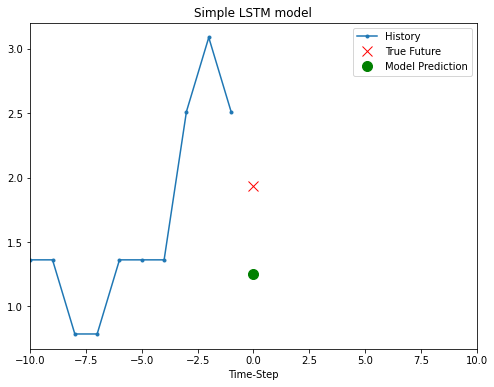

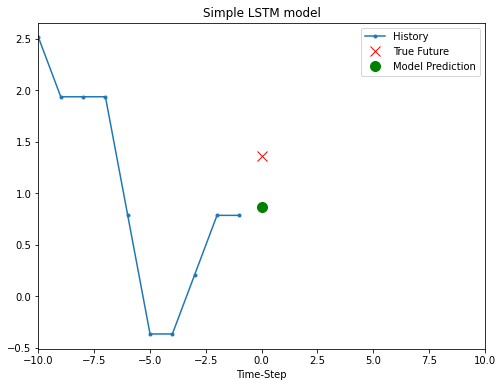

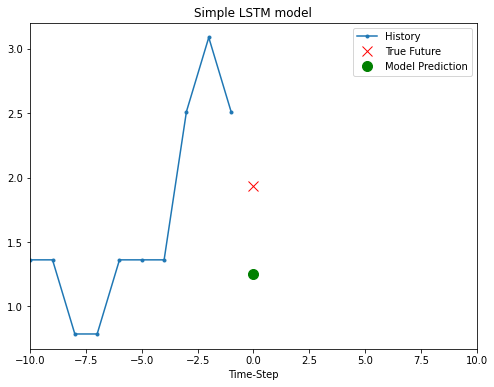

In [134]:
for x, y in val_univariate.take(3):
  plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
  plot.show()

In [135]:
features_considered = ['Nature_rune', 'Soul_rune', 'Law_rune']

In [136]:
features = df[features_considered]
features.index = df['timestamp']
features.head()

,Nature_rune,Soul_rune,Law_rune
timestamp,,,
1616025600000,191,143,144
1616112000000,187,143,144
1616198400000,188,143,144
1616284800000,185,140,141
1616371200000,186,134,134


array([<AxesSubplot:xlabel='timestamp'>, <AxesSubplot:xlabel='timestamp'>,
       <AxesSubplot:xlabel='timestamp'>], dtype=object)

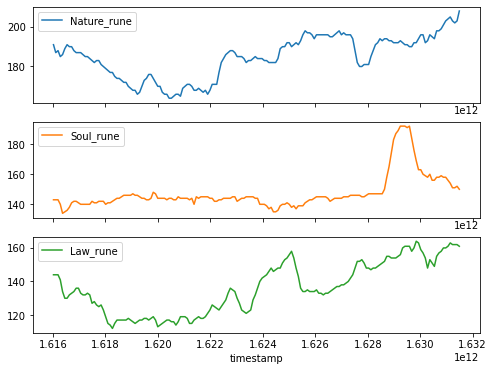

In [137]:
features.plot(subplots=True)

In [138]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

In [139]:
dataset = (dataset-data_mean)/data_std

In [140]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [141]:
past_history = 10
future_target = 1
STEP = 1

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

In [142]:
print ('Single window of past history : {}'.format(x_train_single[0].shape))

Single window of past history : (10, 3)


In [143]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [144]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32,
                                           input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

In [145]:
for x, y in val_data_single.take(1):
  print(single_step_model.predict(x).shape)

(20, 1)


In [146]:
single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50)

Epoch 1/15
500/500 [==============================] - 4s 5ms/step - loss: 0.3607 - val_loss: 7.2705
Epoch 2/15
500/500 [==============================] - 2s 4ms/step - loss: 0.2332 - val_loss: 7.2127
Epoch 3/15
500/500 [==============================] - 2s 4ms/step - loss: 0.1933 - val_loss: 7.4345
Epoch 4/15
500/500 [==============================] - 2s 4ms/step - loss: 0.1761 - val_loss: 7.6775
Epoch 5/15
500/500 [==============================] - 2s 4ms/step - loss: 0.1638 - val_loss: 7.7426
Epoch 6/15
500/500 [==============================] - 2s 4ms/step - loss: 0.1552 - val_loss: 7.7988
Epoch 7/15
500/500 [==============================] - 2s 4ms/step - loss: 0.1457 - val_loss: 7.7907
Epoch 8/15
500/500 [==============================] - 2s 4ms/step - loss: 0.1377 - val_loss: 7.8153
Epoch 9/15
500/500 [==============================] - 2s 4ms/step - loss: 0.1299 - val_loss: 7.8058
Epoch 10/15
500/500 [==============================] - 2s 4ms/step - loss: 0.1217 - val_loss: 7.7618

In [147]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

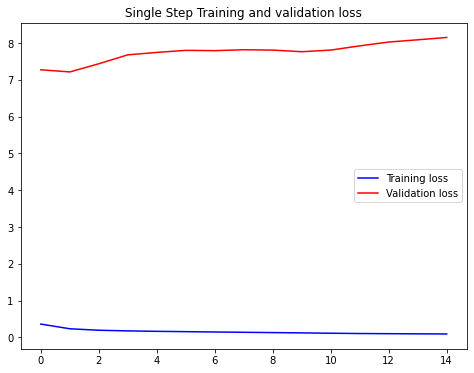

In [148]:
plot_train_history(single_step_history,
                   'Single Step Training and validation loss')

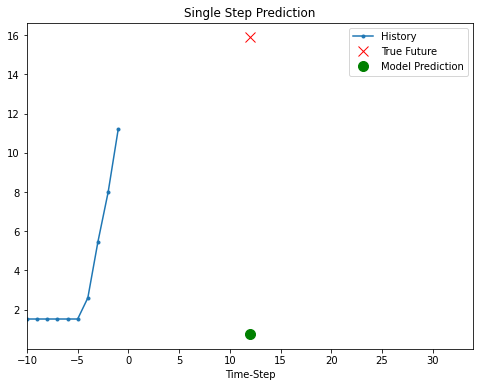

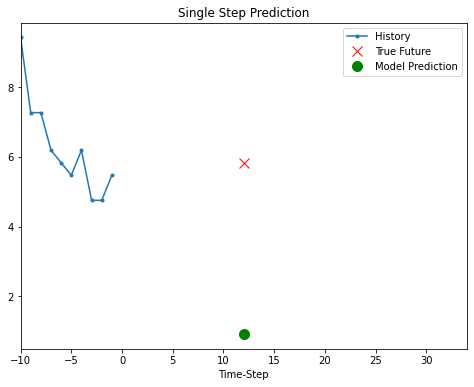

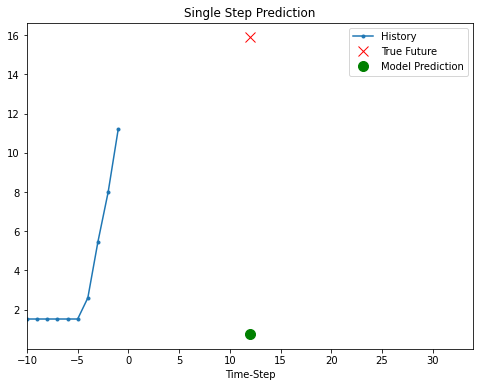

In [149]:
for x, y in val_data_single.take(3):
  plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 12,
                   'Single Step Prediction')
  plot.show()

In [150]:
future_target = 5
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

In [151]:
print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\n Target price to predict : {}'.format(y_train_multi[0].shape))

Single window of past history : (10, 3)

 Target price to predict : (5,)


In [152]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [153]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

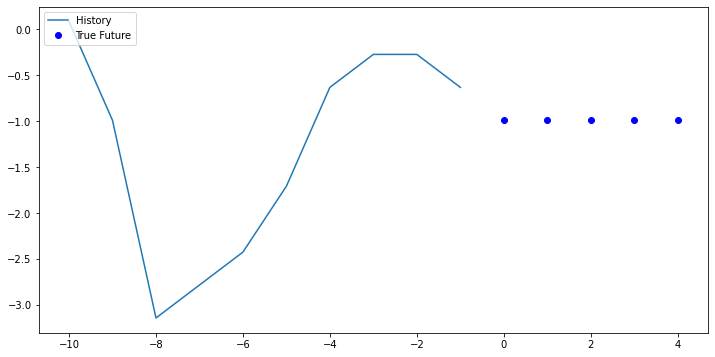

In [154]:
for x, y in train_data_multi.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))

In [160]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
#multi_step_model.add(tf.keras.layers.Dense(72))
multi_step_model.add(tf.keras.layers.Dense(future_target))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

In [161]:
for x, y in val_data_multi.take(1):
  print (multi_step_model.predict(x).shape)

(20, 5)


In [162]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Epoch 1/15
500/500 [==============================] - 6s 7ms/step - loss: 0.4863 - val_loss: 7.4187
Epoch 2/15
500/500 [==============================] - 3s 7ms/step - loss: 0.2620 - val_loss: 8.1638
Epoch 3/15
500/500 [==============================] - 3s 7ms/step - loss: 0.2147 - val_loss: 8.0146
Epoch 4/15
500/500 [==============================] - 3s 6ms/step - loss: 0.2046 - val_loss: 7.9902
Epoch 5/15
500/500 [==============================] - 3s 6ms/step - loss: 0.1963 - val_loss: 8.1264
Epoch 6/15
500/500 [==============================] - 4s 7ms/step - loss: 0.1905 - val_loss: 8.0731
Epoch 7/15
500/500 [==============================] - 3s 6ms/step - loss: 0.1831 - val_loss: 7.8685
Epoch 8/15
500/500 [==============================] - 3s 6ms/step - loss: 0.1777 - val_loss: 7.6361
Epoch 9/15
500/500 [==============================] - 3s 6ms/step - loss: 0.1717 - val_loss: 7.6104
Epoch 10/15
500/500 [==============================] - 3s 7ms/step - loss: 0.1664 - val_loss: 7.6030

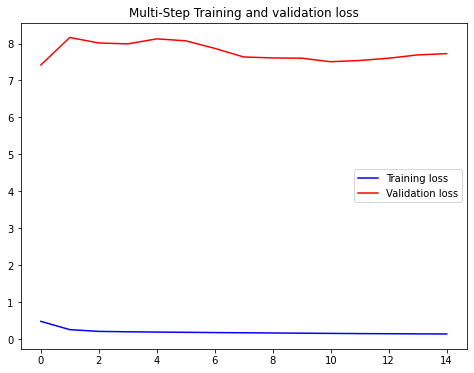

In [163]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

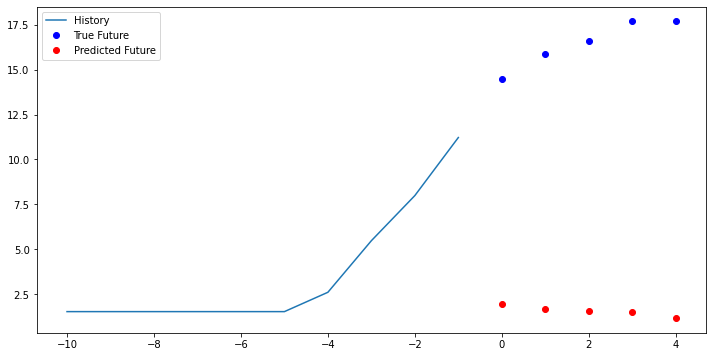

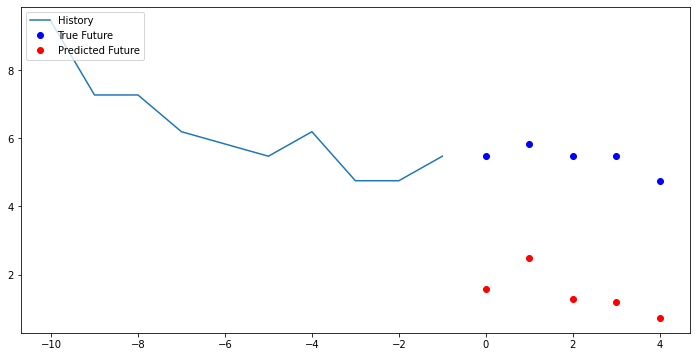

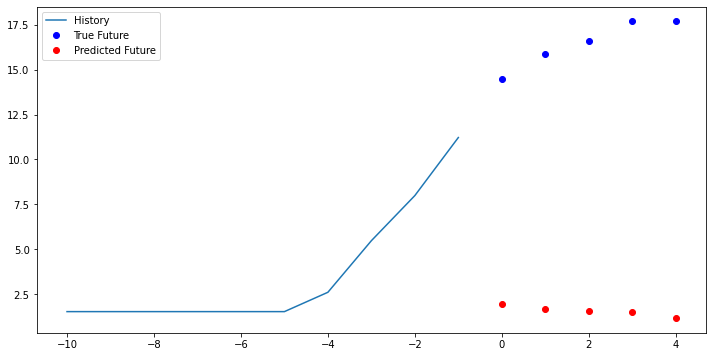

In [164]:
for x, y in val_data_multi.take(3):
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])